# Studying the details of non-local means
A. Kaestner<br/> Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, Switzerland<br/>
<br/>
Non-local means is a popular method for denoising images. Here, we look at what the filter is doing. 


## Load some packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
import skimage.filters as flt
import skimage.restoration as res

%matplotlib inline

# Load test image
The boat image is a often used test image with many line features.

(512, 512)


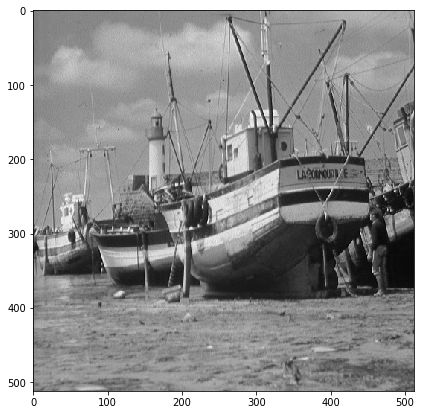

In [13]:

img=plt.imread('boat.png')
plt.figure(figsize=[7,7])
plt.imshow(img,cmap='gray')
print(img.shape)

# Look at different local neighborhoods

In [3]:
def region(img,pos,M2) :
    return img[(pos[0]-M2):(pos[0]+M2+1),(pos[1]-M2):(pos[1]+M2+1)]

In [4]:
def showRegions(img,pos1,pos2,M2) :
    plt.figure(figsize=(15,8))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')

    plt.plot(pos1[1],pos1[0],'ro')
    plt.plot(pos2[1],pos2[0],'yo')

    plt.subplot(1,3,2)
    r1=region(img,pos1,M2)
    plt.imshow(r1,clim=[0,1])
    plt.title('Region at position 1')

    plt.subplot(1,3,3)
    r2=region(img,pos2,M2)
    plt.imshow(r2,clim=[0,1])
    plt.title('Region at position 2')
    
    idiff=np.abs(np.mean(r1)-np.mean(r2))
    print('Intensity difference between r1 and r2 is',idiff)
    
    dx=pos1[0]-pos2[0]
    dy=pos1[1]-pos2[1]
    dist= np.sqrt(dx**2+dy**2)
    print('Euclidean distance between p1 and p2 is',dist)
    
    return idiff,dist

Let's look at 5x5-neighborhoods around some pixels 

Intensity difference between r1 and r2 is 0.447059
Euclidean distance between p1 and p2 is 20.0


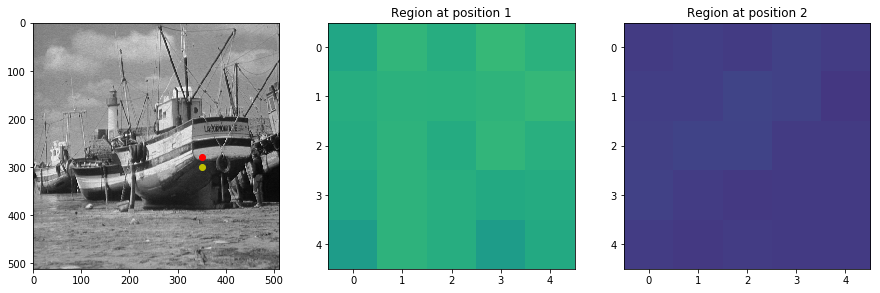

In [5]:
plt.figure(figsize=(15,8))
M=5
pos1=[280,350]
pos2=[300,350]
M2=int(M/2)
idiff1,dist1=showRegions(img,pos1,pos2,M2)

As you can see, there is great difference between the average intensity in these two neighborhoods. This means, we don't want them to contribute to each others average. Let's try two new pixels:

Intensity difference between r1 and r2 is 0.0241568
Euclidean distance between p1 and p2 is 308.058436015


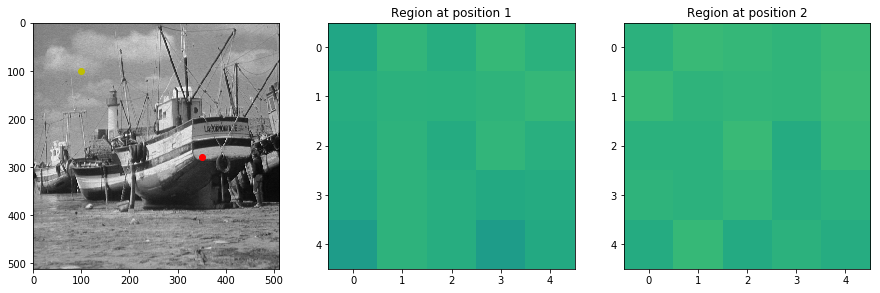

In [6]:
plt.figure(figsize=(15,8))
plt.figure(figsize=(15,8))
M=5
pos3=[280,350]
pos4=[100,100]
M2=int(M/2)
idiff2,dist2=showRegions(img,pos3,pos4,M2)

These positions are much more similar and there would be a benefit to combine these two positions in an average.

Comparing at the intensity difference and euclidean distance for the two positions we see that region remote from a pixel can be used to compute an average. This leads us to the non-local means.

# Non-local means algorithm

$u(p)=\frac{1}{C(p)}\sum_{q\in\Omega}v(q)\,f(p,q)$

where
- $v$ and $u$ input and result images.
- $C(p)$ is the sum of all pixel weights as <br/>$C(p)=\sum_{q\in\Omega}f(p,q)$

- $f(p,q)$ is a weight function based on the intensity difference between the pixels $p$ and $q$ <br/>$f(p,q)=e^{-\frac{|B(q)-B(p)|^2}{h^2}}$
- $B(p)=\sum_{i\in N_p} w(i-p)\cdot v(i)$, where $w(i)$ are the weights. The simple case all $w(i)=1$, but it could also be Gaussian or binomial weights.

A. Buades, "A non-local algorithm for image denoising". Computer Vision and Pattern Recognition, 2005. 2: 60–65. doi:10.1109/CVPR.2005.38.


## Looking at the diffence weights for the image relative to a single position 

In [7]:
def nlm_singlepos(img,pos,M,h) :
    res=ndimage.filters.uniform_filter(img,M)
    ref=img[pos[0],pos[1]]
    for r in np.arange(0,img.shape[0]) :
        for c in np.arange(0,img.shape[1]) :
            res[r,c] = np.exp(-(res[r,c]-ref)**2/h)
    
    res=res/np.sum(res)
    return res

In [8]:
def testPos(img,pos,M,h) :
    sub=nlm_singlepos(img,pos,M,h)
    plt.imshow(sub, cmap='gray')
    plt.plot(pos[1],pos[0],'or')
    print(np.min(sub),np.max(sub))

1.83777e-20 7.54941e-06
4.35332e-28 3.68596e-05
1.3724e-23 1.21196e-05


Text(0.5,1,'Clouds')

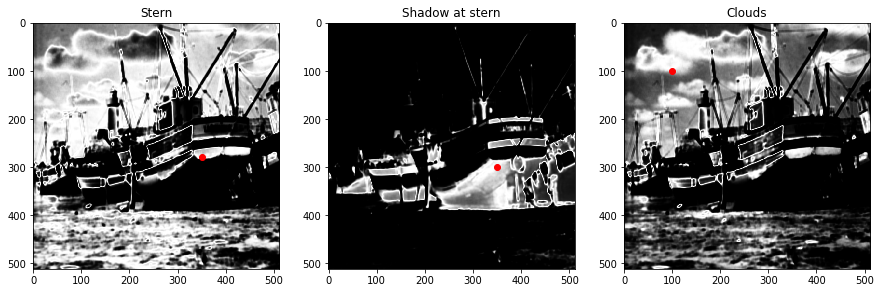

In [9]:
plt.figure(figsize=(15,8))
h=0.01

plt.subplot(1,3,1)
testPos(img,pos1,5,h)
plt.title('Stern')

pos=(230,400)
plt.subplot(1,3,2)
testPos(img,pos2,5,h)
plt.title('Shadow at stern')

pos=(350,300)
plt.subplot(1,3,3)
testPos(img,pos4,5,h)
plt.title('Clouds')

Now you can see that the weight for the clouds and the stern are more similar than the shadow region. This is confirmed by the previous finding that the intensity difference is much less between these postions than to the shadow area. This is the concept of non-locality, pixels with small intensity difference are summed up. It doesn't matter how far Euclidean distance separating them.

The new pixel value is computed as the sum of the product between image and weights. This will then be repeated for all pixels to obtain the filtered image.

## Try parameter $h$ 
Parameter $h$ controls the sensitivity of the filter. Below, you can see what happens when $h$ is increased.

0.01
2.85991e-18 2.58623e-05
0.02
4.89104e-12 1.47082e-05
0.05
1.98053e-08 7.7276e-06
0.1
2.86791e-07 5.66495e-06


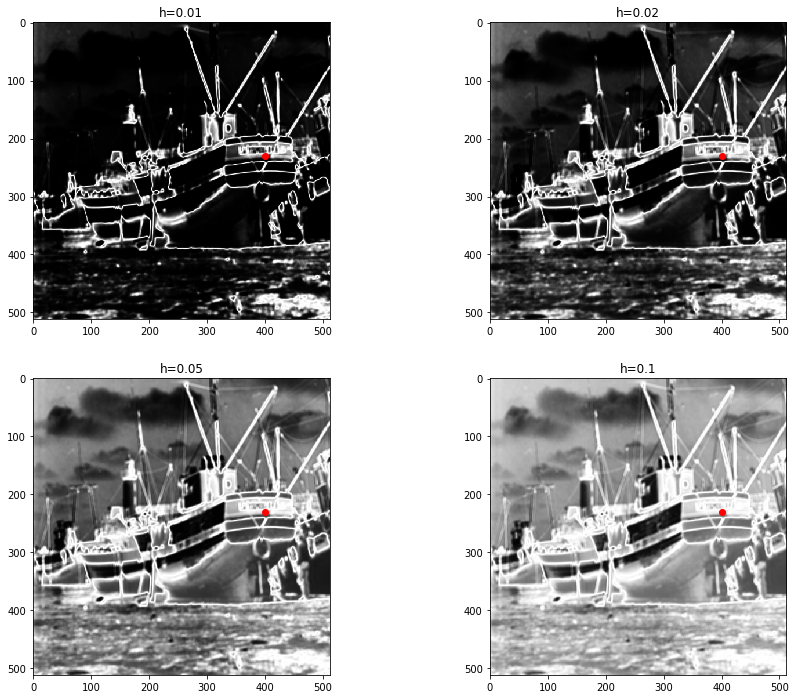

In [10]:
plt.figure(figsize=[15,12])
parH=[0.01,0.02,0.05,0.1]
pos=(230,400)

for i in range(len(parH)) :
    print(parH[i])
    plt.subplot(2,2,i+1)
    fimg=testPos(img,pos,5,h=parH[i])

    plt.title('h={}'.format(parH[i]))

The effect of a greater value on $h$ is that a wider range of pixel values are considered for the average computation of a position. If you look at $h=0.01$, only very similar values are considered. This changes when $h$ increase and for the case of $h=0.1$ a great number of pixels contribute to the average.

# Putting it all together
The non-local means filter is implemented in scikit image (module restoration). Basic use with default parameters gives:

/Users/kaestner/anaconda3/lib/python3.6/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


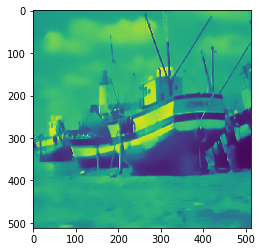

In [11]:
nlm=res.denoise_nl_means(img,)
plt.imshow(nlm)

I.e. rather strong filter effect. But as you can see, edges are still well-preserved. You may think that the filter effect is too strong and provide patchy (piecewise constant) results. This can be tuned with sensitivity parameter $h$.

## Try parameter $h$
Let's try what happens when the sensitivity parameter h changes:

0.01


/Users/kaestner/anaconda3/lib/python3.6/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


0.02
0.05
0.1


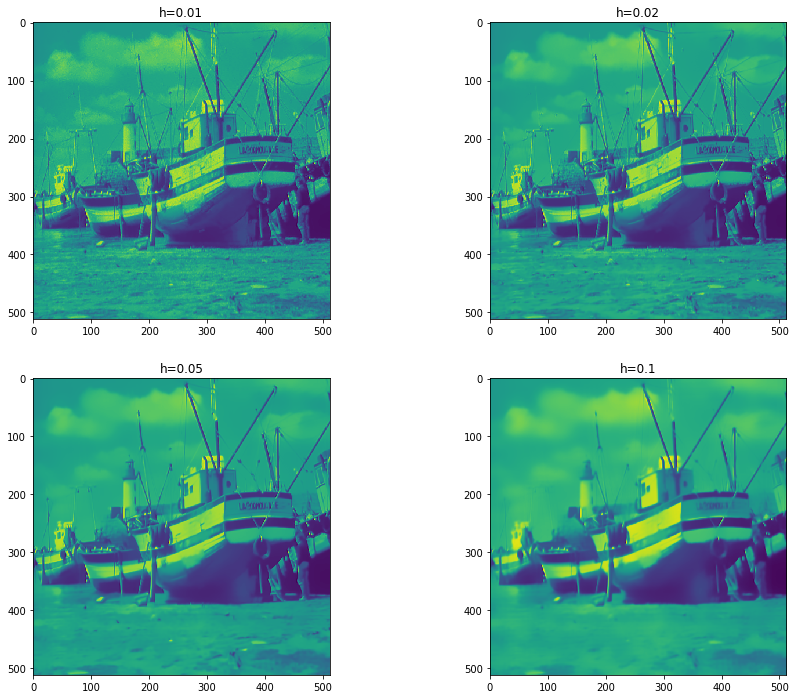

In [12]:
plt.figure(figsize=[15,12])
parH=[0.01,0.02,0.05,0.1]

for i in range(len(parH)) :
    print(parH[i])
    fimg=res.denoise_nl_means(img,h=parH[i])
    plt.subplot(2,2,i+1)
    plt.imshow(fimg)
    plt.title('h={}'.format(parH[i]))

## Try noise performance
Now let's add some noise to the data:
### Gaussian
Gaussian noise can be handled well, but there may be a need to adjust $h$ to cope with lower SNR

/Users/kaestner/anaconda3/lib/python3.6/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


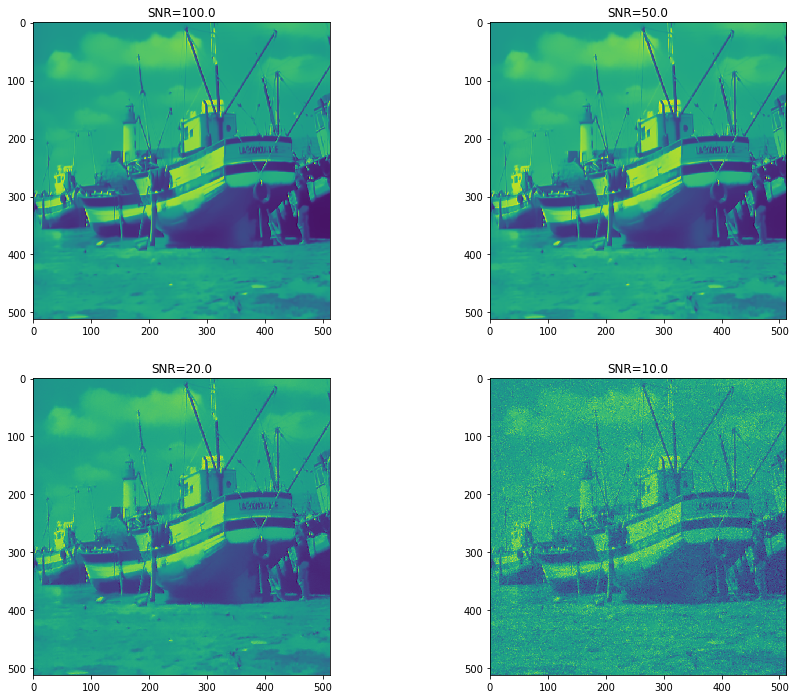

In [14]:
SNR=[0.01, 0.02,0.05, 0.1]
plt.figure(figsize=[15,12])

for i in range(len(SNR)) :
    nimg=img+np.random.normal(0,SNR[i],size=img.shape)
    fimg=res.denoise_nl_means(nimg,h=0.05) 
    plt.subplot(2,2,i+1)
    plt.imshow(fimg)
    plt.title('SNR={}'.format(1/SNR[i]))

Using $h=0.05$ the filter handles high SNR well, but the performance braks down for SNR=10. Try to see how it performs with $h=0.1$.

Now you can see that the weight for the clouds and the stern are more similar than the shadow region. This is confirmed by the previous finding that the intensity difference is much less between these postions than to the shadow area. This is the concept of non-locality, pixels with small intensity difference are summed up. It doesn't matter how far Euclidean distance separating them.

In [15]:
pwd

'/Users/kaestner/git/scriptorium/Lectures/ImageEnhancement/trunk/python/nonLocalMeans'